In [1]:
import pandas as pd
import numpy as np
import sqlite3
import plotly.express as px

# Chargement des donnees

In [2]:
clean = '../../datas/CLEAN/E2/'

con = sqlite3.connect(clean + 'E2.db')
df = pd.read_sql('select * from clean_data', con, index_col='index')

con.close()

df[df.columns[:16]].head(5)

,order_item_id,shipping_limit_date,price,freight_value,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_city,customer_state,seller_city,seller_state,weight,volume
index,,,,,,,,,,,,,,,,
0,4,2018-01-24 20:14:08,23.0,15.79,delivered,2018-01-18 19:54:00,2018-01-18 20:14:08,2018-01-19 18:32:18,2018-01-26 19:04:07,2018-02-14 00:00:00,rio de janeiro,RJ,curitiba,PR,1000.0,2040.0
1,3,2018-01-24 20:14:08,23.0,15.79,delivered,2018-01-18 19:54:00,2018-01-18 20:14:08,2018-01-19 18:32:18,2018-01-26 19:04:07,2018-02-14 00:00:00,rio de janeiro,RJ,curitiba,PR,1000.0,2040.0
2,2,2018-01-24 20:14:08,23.0,15.79,delivered,2018-01-18 19:54:00,2018-01-18 20:14:08,2018-01-19 18:32:18,2018-01-26 19:04:07,2018-02-14 00:00:00,rio de janeiro,RJ,curitiba,PR,1000.0,2040.0
3,1,2018-01-24 20:14:08,23.0,15.79,delivered,2018-01-18 19:54:00,2018-01-18 20:14:08,2018-01-19 18:32:18,2018-01-26 19:04:07,2018-02-14 00:00:00,rio de janeiro,RJ,curitiba,PR,1000.0,2040.0
4,1,2017-03-24 18:22:46,22.0,14.52,delivered,2017-03-20 18:22:46,2017-03-20 18:22:46,2017-03-21 13:35:58,2017-03-27 12:30:15,2017-04-12 00:00:00,rio de janeiro,RJ,jacarei,SP,200.0,640.0


# Calcul des delais de livraison et leur exploration

In [3]:
for col in df.columns[5:10]:
    df[col] = pd.to_datetime(df[col])
df['shipping_limit_date'] = pd.to_datetime(df['shipping_limit_date'])

df.select_dtypes(include=np.datetime64).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105250 entries, 0 to 105249
Data columns (total 6 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   shipping_limit_date            105250 non-null  datetime64[ns]
 1   order_purchase_timestamp       105250 non-null  datetime64[ns]
 2   order_approved_at              105250 non-null  datetime64[ns]
 3   order_delivered_carrier_date   105250 non-null  datetime64[ns]
 4   order_delivered_customer_date  105250 non-null  datetime64[ns]
 5   order_estimated_delivery_date  105250 non-null  datetime64[ns]
dtypes: datetime64[ns](6)
memory usage: 5.6 MB


In [4]:
from modules.data_cleaning import get_time_gap
from modules.data_cleaning import apply_zscore

target = get_time_gap(df.order_purchase_timestamp, df.order_delivered_customer_date  )
df.insert(0, 'shipping_delay', target)

temp = get_time_gap(df.order_purchase_timestamp, df.order_estimated_delivery_date)
df.insert(0, 'estimated_delay', temp)

print(df.shape)
df = apply_zscore(df, ['shipping_delay', 'estimated_delay'])
df = df.reset_index(drop=True)
print(df.shape)

print('shipping_delay\n', df.shipping_delay.describe())
print('estimated_delay\n', df.estimated_delay.describe())

(105250, 91)
(102481, 91)
shipping_delay
 count    102481.000000
mean         11.603725
std           7.137707
min           0.533414
25%           6.485949
50%          10.001701
75%          15.011354
max          40.419826
Name: shipping_delay, dtype: float64
estimated_delay
 count    102481.000000
mean         23.245409
std           8.009958
min           2.008009
25%          18.182847
50%          23.067407
75%          28.183715
max          50.014572
Name: estimated_delay, dtype: float64


## L'estimation est en retard face à la réalité

En moyenne l'estimation officielle plus importante de 12 jours !

<AxesSubplot:>

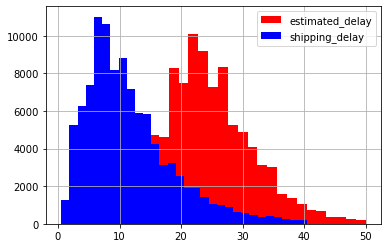

In [5]:
fig = df.estimated_delay.hist(color='red', bins=30, legend=True)
df.shipping_delay.hist(color='blue', bins=30, legend=True)

In [6]:
df.columns[:20]

Index(['estimated_delay', 'shipping_delay', 'order_item_id',
       'shipping_limit_date', 'price', 'freight_value', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'customer_city', 'customer_state',
       'seller_city', 'seller_state', 'weight', 'volume', 'cool_stuff',
       'pet_shop'],
      dtype='object')

In [7]:
cols = ['weight', 'volume', 'price', 'freight_value']
print('estimated\n', df[cols].corrwith(df['estimated_delay']))
print('\nshipping_delay\n', df[cols].corrwith(df['shipping_delay']))
print('Correlation entre estimation officielle et realité', df.estimated_delay.corr(df.shipping_delay))

estimated
 weight           0.056809
volume           0.054694
price            0.082110
freight_value    0.362542
dtype: float64

shipping_delay
 weight           0.060024
volume           0.055061
price            0.072569
freight_value    0.300549
dtype: float64
Correlation entre estimation officielle et realité 0.44227209093465786


# Extraction de features

### Mois et jour de la semaine

L'information du mois n'est pas equitablement repartie à cause de la periode du jeu de données

Le mois de septembre est le moins représenté 2.5 fois moins que aout

In [8]:
temp = pd.Series([date.month_name() for date in df.order_purchase_timestamp])
df.insert(0, 'month', temp)
px.bar(temp.value_counts().sort_index(), height=300)

In [9]:
temp = pd.Series([date.day_name() for date in df.order_purchase_timestamp])
df.insert(0, 'day_of_week', temp)
px.bar(temp.value_counts().sort_index(), height=300)

### Extraction de la distance

In [10]:
from modules.data_engineering import Geocoder

line = df.iloc[0]
adr1 = ' '.join([line.customer_city, line.customer_state, 'brazil'])
adr2 = ' '.join([line.seller_city, line.seller_state, 'brazil'])

bg = Geocoder()
temp = bg.get_distance(adr1, adr2)
temp

675.6106452602173

In [31]:
limb = 0
limh = limb + 50

adresses = [
    [
        ' '.join([row.customer_city, row.customer_state, 'brazil']),
        ' '.join([row.seller_city, row.seller_state, 'brazil'])
    ]
    for row 
    in df[limb:limh][['customer_city', 'customer_state', 'seller_city', 'seller_state']].itertuples(index=False)
]
adresses

[['rio de janeiro RJ brazil', 'curitiba PR brazil'],
 ['rio de janeiro RJ brazil', 'curitiba PR brazil'],
 ['rio de janeiro RJ brazil', 'curitiba PR brazil'],
 ['rio de janeiro RJ brazil', 'curitiba PR brazil'],
 ['rio de janeiro RJ brazil', 'jacarei SP brazil'],
 ['ribeirao pires SP brazil', 'sao paulo SP brazil'],
 ['curitiba PR brazil', 'joinville SC brazil'],
 ['rio de janeiro RJ brazil', 'barra mansa RJ brazil'],
 ['pinhais PR brazil', 'sao paulo SP brazil'],
 ['sao paulo SP brazil', 'sao paulo SP brazil']]

In [32]:
coords = bg.batch(adresses)
coords[:10]

[[-22.9110145568848, -43.2093734741211],
 [-22.9110145568848, -43.2093734741211],
 [-22.9110145568848, -43.2093734741211],
 [-22.9110145568848, -43.2093734741211],
 [-22.9110145568848, -43.2093734741211],
 [-23.7129383087158, -46.4150886535645],
 [-25.4295959472656, -49.2712707519531],
 [-23.0482501983643, -43.6574745178223],
 [-23.550651550293, -46.6333808898926],
 [-23.550651550293, -46.6333808898926]]

In [26]:
def distance(row):
    dst = bg.get_distance(
    )
    print(dst)

# df[['customer_city', 'customer_state', 'seller_city', 'seller_state']].i

675.6106452602173
675.6106452602173
675.6106452602173
675.6106452602173
285.2958984768742
28.63817992308994


KeyboardInterrupt: 